In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install pyefd

In [3]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from pyefd import elliptic_fourier_descriptors

class DataLoader:
    def __init__(self, dataset_path, img_size=(32, 32), test_size=0.2):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.test_size = test_size
        self.label_mapping = {
            "bào ngư xám + trắng": 1,
            "Đùi gà Baby (cắt ngắn)": 2,
            "linh chi trắng": 3,
            "nấm mỡ": 0
        }
    
    def extract_shape_features(self, image):
        """Tạo đặc trưng hình dạng từ ảnh dựa trên Hu Moments."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()
            return hu_moments
        return np.zeros(7)

    def extract_color_histogram(self, image):
        """Tạo histogram màu từ ảnh."""
        chans = cv2.split(image)
        hist_features = []
        for chan in chans:
            hist = cv2.calcHist([chan], [0], None, [32], [0, 256])
            hist_features.extend(hist.flatten())
        return np.array(hist_features)

    def extract_gabor_features(self, image):
        """Tạo đặc trưng Gabor từ ảnh."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gabor_kernels = [cv2.getGaborKernel((5, 5), sigma, np.pi/4, 10, 0.5, 0, ktype=cv2.CV_32F)
                         for sigma in (1, 3, 5)]
        gabor_features = [cv2.filter2D(gray, cv2.CV_8UC3, kernel).mean() for kernel in gabor_kernels]
        return np.array(gabor_features)

    def extract_lbp(self, image):
        """Tạo đặc trưng LBP từ ảnh."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(27), range=(0, 26))
        return hist / hist.sum()

    def extract_glcm_features(self, image):
        """Tạo đặc trưng kết cấu GLCM từ ảnh."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        distances = [1, 2]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        glcm_features = [graycoprops(glcm, prop).mean() for prop in props]
        return np.array(glcm_features)

    def extract_hog_features(self, image):
        """Tạo đặc trưng HOG từ ảnh."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm="L2-Hys")
        return hog_features

    def extract_efd_features(self, image, n_harmonics=10):
        """
        Tạo đặc trưng EFD từ đường bi của đối tượng.
        Trả về vector [A1, B1, C1, D1, ..., A_n, B_n, C_n, D_n].
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            cnt = cnt.squeeze()
            if cnt.ndim < 2 or cnt.shape[0] < 3:
                return np.zeros(n_harmonics * 4)
            coeffs = elliptic_fourier_descriptors(cnt, order=n_harmonics, normalize=True)
            return coeffs.flatten()
        return np.zeros(n_harmonics * 4)

    def extract_ltp(self, image, P=8, R=1, threshold=5):
        """
        Tạo đặc trưng LTP từ ảnh.
        LTP là biến thể của LBP với ba trạng thái: 
          - 1 nếu hiệu số > threshold,
          - 0 nếu hiệu số nằm trong [-threshold, threshold],
          - -1 nếu hiệu số < -threshold.
        Sau đó, tính histogram cho LTP dương và âm và kết hợp lại.
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image

        pad = R
        padded = np.pad(gray, pad_width=pad, mode='edge')
        h, w = gray.shape
        ltp_pos = np.zeros((h, w), dtype=np.uint8)
        ltp_neg = np.zeros((h, w), dtype=np.uint8)
        
        offsets = [(-1, -1), (-1, 0), (-1, 1),
                   (0, -1),           (0, 1),
                   (1, -1),  (1, 0),  (1, 1)]
        
        for i, (dx, dy) in enumerate(offsets):
            shifted = padded[pad+dx: pad+dx+h, pad+dy: pad+dy+w]
            diff = shifted.astype(np.int32) - gray.astype(np.int32)
            pos = (diff > threshold).astype(np.uint8)
            neg = (diff < -threshold).astype(np.uint8)
            ltp_pos += pos << i
            ltp_neg += neg << i
        
        hist_pos, _ = np.histogram(ltp_pos.ravel(), bins=np.arange(2**P+1), density=True)
        hist_neg, _ = np.histogram(ltp_neg.ravel(), bins=np.arange(2**P+1), density=True)
        ltp_features = np.hstack([hist_pos, hist_neg])
        return ltp_features

    def extract_cap_curvature(self, image):
        """
        Tính toán độ cong của mũ nấm:
        - Fit ellipse cho đường bi của đối tượng (giả sử đây là mũ nấm).
        - Tính eccentricity (độ lệch của ellipse): càng cao, mũ càng có hình dạng trụ/chuông; càng thấp, mũ gần tròn (phẳng).
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return np.array([0.0])
        cnt = max(contours, key=cv2.contourArea)
        if cnt.shape[0] < 5:
            return np.array([0.0])
        ellipse = cv2.fitEllipse(cnt)
        (x, y), (MA, ma), angle = ellipse
        if MA < ma:
            MA, ma = ma, MA
        eccentricity = np.sqrt(1 - (ma/MA)**2)
        return np.array([eccentricity])

    def extract_cap_stem_ratio(self, image):
        """
        Tính tỷ lệ diện tích mũ/thân:
        - Giả sử phần trên của ảnh là mũ và phần dưới là thân.
        - Tính số pixel không background (theo threshold) của vùng mũ và thân.
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        h, w = binary.shape
        cap_region = binary[:int(0.5 * h), :]   # Giả sử mũ nằm ở nửa trên
        stem_region = binary[int(0.5 * h):, :]   # Thân nằm ở nửa dưới
        cap_area = np.sum(cap_region > 0)
        stem_area = np.sum(stem_region > 0)
        if stem_area == 0:
            return np.array([0.0])
        ratio = cap_area / stem_area
        return np.array([ratio])

    def extract_symmetry(self, image):
        """
        Tính độ đối xứng của ảnh theo chiều ngang.
        - Lật ảnh theo chiều ngang và tính độ lệch trung bình giữa ảnh gốc và ảnh lật.
        - Điểm đối xứng = 1 - (mean difference / 255)
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        flipped = cv2.flip(gray, 1)
        diff = cv2.absdiff(gray, flipped)
        symmetry_score = 1 - np.mean(diff) / 255.0
        return np.array([symmetry_score])
    
    def denoise_image(self, image):
        """
        Khử nhiễu ảnh bằng phương pháp Non-Local Means (NLM).
        """
        return cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
    
    def load_data(self, use_shape=True, use_color=True, use_gabor=True, 
                  use_lbp=True, use_glcm=True, use_efd=True, use_hog=True, use_ltp=True,
                  use_cap_curvature=True, use_cap_stem_ratio=True, use_symmetry=True):
        """Load dữ liệu từ thư mục dataset và trích xuất các đặc trưng riêng biệt."""
        images, labels, features, efd_features, extra_features = [], [], [], [], []
    
        for class_name, label in self.label_mapping.items():
            class_path = os.path.join(self.dataset_path, class_name)
            if not os.path.exists(class_path):
                print(f"Folder {class_name} không tồn tại, bỏ qua...")
                continue
    
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
    
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img) / 255.0
                img_uint8 = (img_array * 255).astype(np.uint8)
                img_uint8 = self.denoise_image(img_uint8)
    
                feature_vector = []
    
                if use_shape:
                    feature_vector.extend(self.extract_shape_features(img_uint8))
                if use_hog:
                    feature_vector.extend(self.extract_hog_features(img_uint8))
                if use_color:
                    feature_vector.extend(self.extract_color_histogram(img_uint8))
                if use_gabor:
                    feature_vector.extend(self.extract_gabor_features(img_uint8))
                if use_lbp:
                    feature_vector.extend(self.extract_lbp(img_uint8))
                if use_glcm:
                    feature_vector.extend(self.extract_glcm_features(img_uint8))
                if use_ltp:
                    feature_vector.extend(self.extract_ltp(img_uint8))
    
                # Thêm các đặc trưng độc đáo khác vào vector extra_features
                extra = []
                if use_cap_curvature:
                    extra.extend(self.extract_cap_curvature(img_uint8))
                if use_cap_stem_ratio:
                    extra.extend(self.extract_cap_stem_ratio(img_uint8))
                if use_symmetry:
                    extra.extend(self.extract_symmetry(img_uint8))
    
                # Ghép các đặc trưng cơ bản và extra
                feature_vector.extend(extra)
    
                images.append(img_array)
                labels.append(label)
                features.append(feature_vector)
    
                if use_efd:
                    efd = self.extract_efd_features(img_uint8)
                    efd_features.append(efd)
    
        images = np.array(images)
        labels = np.array(labels)
        features = np.array(features) if len(features) > 0 else None
        efd_features = np.array(efd_features) if len(efd_features) > 0 else None
    
        return images, labels, features, efd_features
    

    def get_train_test_split(self, use_shape=True, use_color=True, use_gabor=True, 
                             use_lbp=True, use_glcm=True, use_efd=True, use_hog=True, use_ltp=True,
                             use_cap_curvature=True, use_cap_stem_ratio=True, use_symmetry=True):
        """Chia train/test và kết hợp các đặc trưng lại thành 1 vector đặc trưng duy nhất."""
        X, y, features, efd_features = self.load_data(use_shape, use_color, use_gabor, use_lbp, use_glcm, 
                                                      use_efd, use_hog, use_ltp, use_cap_curvature, use_cap_stem_ratio, use_symmetry)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=42, stratify=y
        )
    
        # Nếu cả hai đặc trưng (features và efd_features) tồn tại, thì ghép chúng lại theo chiều thứ 1 (axis=1)
        if features is not None and efd_features is not None:
            combined_features = np.hstack([features, efd_features])
        elif features is not None:
            combined_features = features
        elif efd_features is not None:
            combined_features = efd_features
        else:
            combined_features = None
        
        if combined_features is not None:
            F_train, F_test = train_test_split(combined_features, test_size=self.test_size, random_state=42)
        else:
            F_train, F_test = None, None
    
        return X_train, X_test, y_train, y_test, F_train, F_test

In [4]:
data_loader = DataLoader(dataset_path="/kaggle/input/aio-hutech/train")
X_train, X_test, y_train, y_test, F_train, F_test = data_loader.get_train_test_split()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"F_train shape: {F_train.shape}")
print(f"F_test shape: {F_test.shape}")

X_train shape: (960, 32, 32, 3)
X_test shape: (240, 32, 32, 3)
y_train shape: (960,)
y_test shape: (240,)
F_train shape: (960, 1017)
F_test shape: (240, 1017)


# Visualize

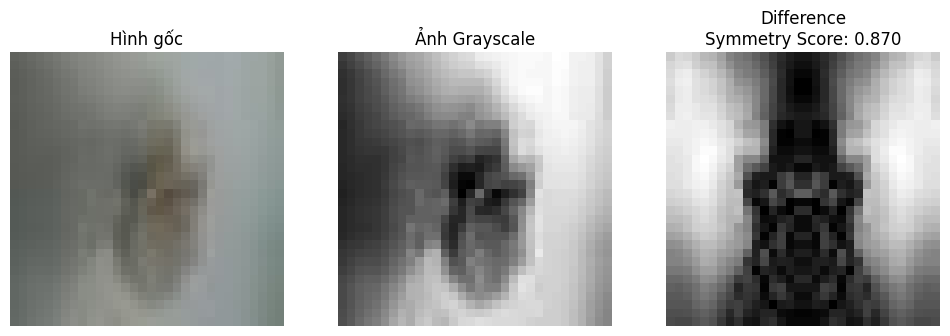

In [5]:
# Chọn một hình mẫu cụ thể từ dataset (thay đổi đường dẫn file cho phù hợp)
img_path = "/kaggle/input/aio-hutech/train/bào ngư xám + trắng/BN001.jpg"  # Thay 'your_image.jpg' bằng tên file cụ thể
img = load_img(img_path, target_size=(32,32))
img_array = img_to_array(img) / 255.0

# Chuyển sang định dạng uint8 cho các bước xử lý OpenCV
img_uint8 = (img_array * 255).astype(np.uint8)

# Sử dụng hàm extract_symmetry từ DataLoader
symmetry_score = data_loader.extract_symmetry(img_uint8)

# Để minh họa, ta cũng tính toán ảnh grayscale, ảnh lật ngang và ảnh hiệu số (chênh lệch)
gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
flipped = cv2.flip(gray, 1)
diff = cv2.absdiff(gray, flipped)

# Hiển thị hình ảnh gốc và hình hiệu số đối xứng
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
# Lưu ý: cv2.cvtColor chuyển đổi BGR -> RGB nếu ảnh được load bởi OpenCV,
# ở đây load_img trả về ảnh RGB nên ta có thể hiển thị trực tiếp.
plt.imshow(img_array)
plt.title("Hình gốc")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gray, cmap='gray')
plt.title("Ảnh Grayscale")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(diff, cmap='gray')
plt.title(f"Difference\nSymmetry Score: {symmetry_score[0]:.3f}")
plt.axis("off")

plt.show()

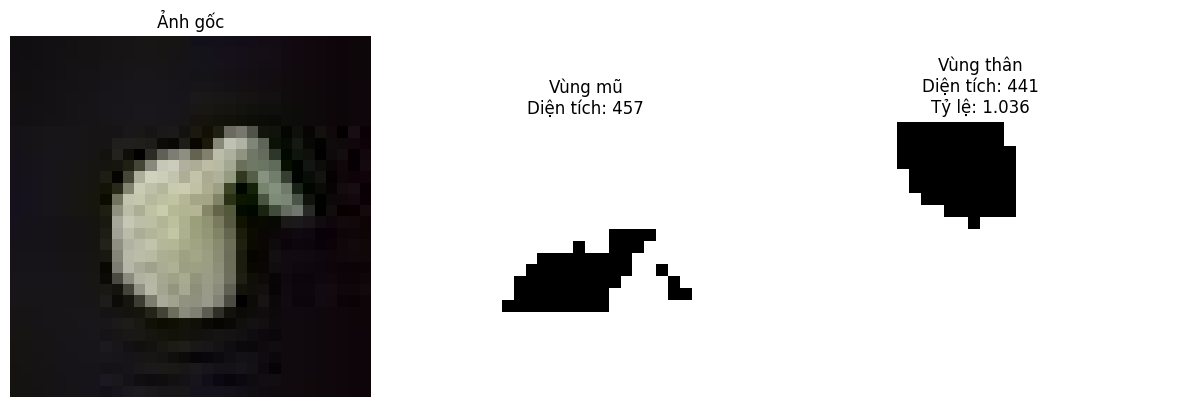

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Giả sử hàm extract_cap_stem_ratio đã được định nghĩa như sau:
def extract_cap_stem_ratio(image):
    """
    Tính toán tỷ lệ diện tích mũ/thân:
    - Giả sử phần trên của ảnh là mũ và phần dưới là thân.
    - Tính số pixel không background (theo threshold) của vùng mũ và vùng thân.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    h, w = binary.shape
    cap_region = binary[:h//2, :]    # Giả sử mũ nằm ở nửa trên
    stem_region = binary[h//2:, :]    # Thân nằm ở nửa dưới
    cap_area = np.sum(cap_region > 0)
    stem_area = np.sum(stem_region > 0)
    if stem_area == 0:
        return np.array([0.0])
    ratio = cap_area / stem_area
    return np.array([ratio]), cap_region, stem_region

# Đường dẫn hình mẫu (thay đổi theo dữ liệu của bạn)
img_path = "/kaggle/input/aio-hutech/train/bào ngư xám + trắng/BN004.jpg"  # Thay tên file cho phù hợp

# Load ảnh và chuyển về định dạng uint8
img = load_img(img_path, target_size=(32, 32))
img_array = img_to_array(img) / 255.0
img_uint8 = (img_array * 255).astype(np.uint8)

# Tính tỷ lệ mũ/thân
ratio, cap_region, stem_region = extract_cap_stem_ratio(img_uint8)

# Hiển thị kết quả:
plt.figure(figsize=(12,4))

# Hiển thị ảnh gốc
plt.subplot(1,3,1)
plt.imshow(img_array)
plt.title("Ảnh gốc")
plt.axis("off")

# Hiển thị vùng mũ (cap)
plt.subplot(1,3,2)
plt.imshow(cap_region, cmap="gray")
plt.title(f"Vùng mũ\nDiện tích: {np.sum(cap_region > 0)}")
plt.axis("off")

# Hiển thị vùng thân (stem)
plt.subplot(1,3,3)
plt.imshow(stem_region, cmap="gray")
plt.title(f"Vùng thân\nDiện tích: {np.sum(stem_region > 0)}\nTỷ lệ: {ratio[0]:.3f}")
plt.axis("off")

plt.tight_layout()
plt.show()

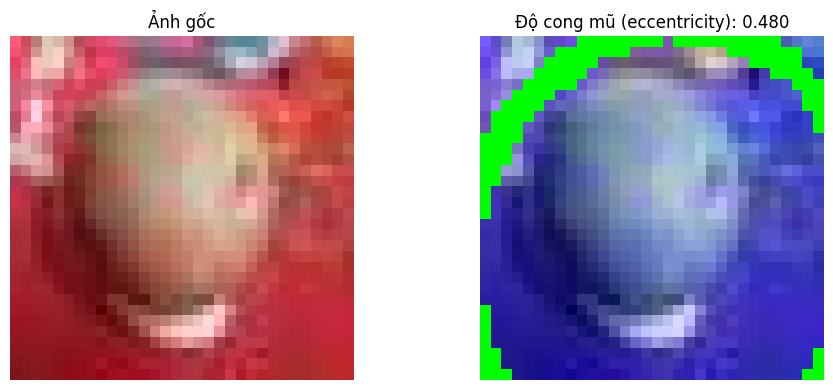

In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def extract_cap_curvature(image):
    """
    Tính toán độ cong của mũ nấm:
    - Fit một ellipse cho đường bi của đối tượng (giả sử đây là mũ nấm).
    - Tính eccentricity của ellipse:
         eccentricity = sqrt(1 - (minor_axis/major_axis)^2)
      Giá trị eccentricity càng cao, mũ nấm càng có hình dạng trụ/chuông; càng thấp thì gần tròn (phẳng).
    """
    # Chuyển ảnh về grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Áp dụng threshold để tạo ảnh nhị phân
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    # Tìm đường bi của đối tượng
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.array([0.0]), None
    cnt = max(contours, key=cv2.contourArea)
    # Để fit ellipse, cần ít nhất 5 điểm
    if cnt.shape[0] < 5:
        return np.array([0.0]), None
    ellipse = cv2.fitEllipse(cnt)
    # ellipse trả về ((x, y), (MA, ma), angle)
    (x, y), (MA, ma), angle = ellipse
    # Đảm bảo MA là trục lớn
    if MA < ma:
        MA, ma = ma, MA
    eccentricity = np.sqrt(1 - (ma/MA)**2)
    return np.array([eccentricity]), ellipse

# Ví dụ sử dụng:
# Thay đổi đường dẫn hình ảnh cho phù hợp với dataset của bạn
img_path = "/kaggle/input/aio-hutech/train/nấm mỡ/NM029.jpg"  
img = load_img(img_path, target_size=(32,32))
img_array = img_to_array(img) / 255.0
# Chuyển ảnh về uint8 cho OpenCV
img_uint8 = (img_array * 255).astype(np.uint8)

# Tính toán độ cong của mũ nấm và lấy ellipse
curvature, ellipse = extract_cap_curvature(img_uint8)

# Vẽ ellipse lên ảnh nếu có
img_with_ellipse = img_uint8.copy()
if ellipse is not None:
    cv2.ellipse(img_with_ellipse, ellipse, (0,255,0), 2)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img_array)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1,2,2)
# Chuyển từ BGR sang RGB nếu cần (OpenCV sử dụng BGR)
plt.imshow(cv2.cvtColor(img_with_ellipse, cv2.COLOR_BGR2RGB))
plt.title(f"Độ cong mũ (eccentricity): {curvature[0]:.3f}")
plt.axis("off")

plt.tight_layout()
plt.show()

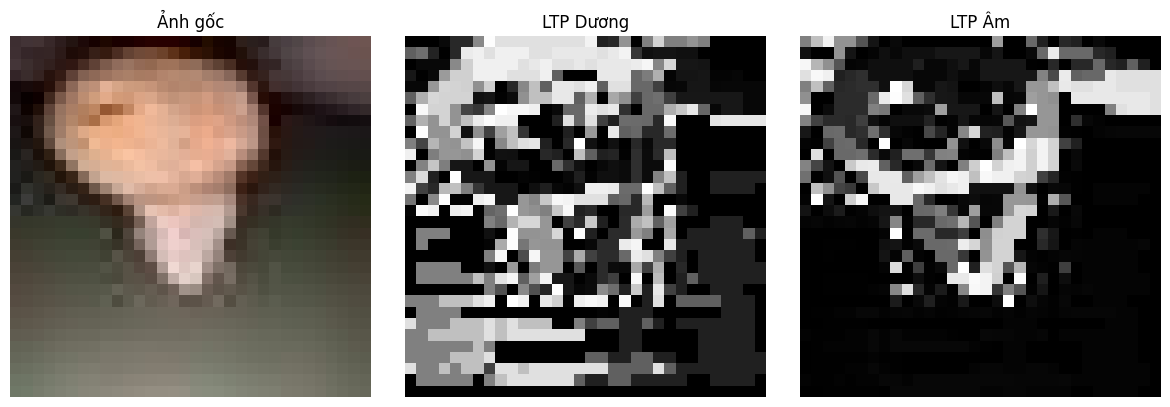

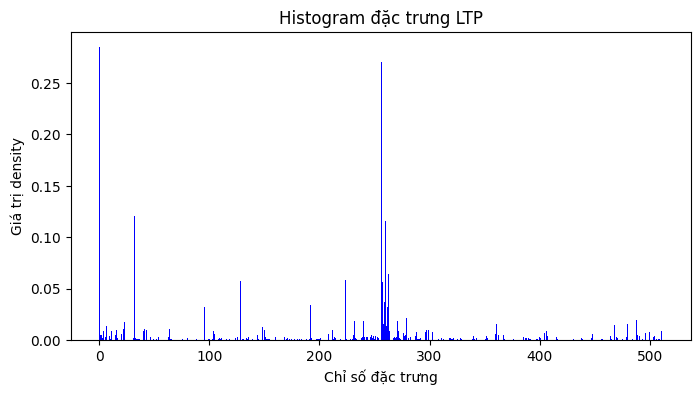

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Hàm extract_ltp (Local Ternary Patterns)
def extract_ltp(image, P=8, R=1, threshold=5):
    """
    Tạo đặc trưng LTP từ ảnh.
    LTP là biến thể của LBP với ba trạng thái: 
      - 1 nếu hiệu số > threshold,
      - 0 nếu hiệu số nằm trong khoảng [-threshold, threshold],
      - -1 nếu hiệu số < -threshold.
    Sau đó, tính histogram cho LTP dương và LTP âm, và kết hợp lại thành một vector đặc trưng.
    """
    # Nếu ảnh chưa là grayscale, chuyển đổi
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Pad ảnh để xử lý biên
    pad = R
    padded = np.pad(gray, pad_width=pad, mode='edge')
    h, w = gray.shape
    # Khởi tạo mảng lưu mã LTP dương và âm
    ltp_pos = np.zeros((h, w), dtype=np.uint8)
    ltp_neg = np.zeros((h, w), dtype=np.uint8)
    
    # Các offset cho cửa sổ 3x3
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1),           (0, 1),
               (1, -1),  (1, 0),  (1, 1)]
    
    for i, (dx, dy) in enumerate(offsets):
        shifted = padded[pad+dx: pad+dx+h, pad+dy: pad+dy+w]
        diff = shifted.astype(np.int32) - gray.astype(np.int32)
        pos = (diff > threshold).astype(np.uint8)
        neg = (diff < -threshold).astype(np.uint8)
        # Tạo mã LTP bằng cách dịch bit theo vị trí offset
        ltp_pos += pos << i
        ltp_neg += neg << i
    
    # Tính histogram cho LTP dương và âm
    hist_pos, _ = np.histogram(ltp_pos.ravel(), bins=np.arange(2**P+1), density=True)
    hist_neg, _ = np.histogram(ltp_neg.ravel(), bins=np.arange(2**P+1), density=True)
    
    # Kết hợp histogram thành vector đặc trưng
    ltp_features = np.hstack([hist_pos, hist_neg])
    return ltp_features, ltp_pos, ltp_neg

# ---- Sử dụng hàm extract_ltp ----

# Đường dẫn hình mẫu (chỉnh sửa theo dữ liệu của bạn)
img_path = "/kaggle/input/aio-hutech/train/Đùi gà Baby (cắt ngắn)/DG008.jpg"  # Thay 'your_image.jpg' bằng tên file cụ thể

# Load ảnh, resize và chuẩn hóa
img = load_img(img_path, target_size=(32, 32))
img_array = img_to_array(img) / 255.0

# Chuyển ảnh về uint8 để xử lý với OpenCV
img_uint8 = (img_array * 255).astype(np.uint8)

# Trích xuất đặc trưng LTP
ltp_features, ltp_pos, ltp_neg = extract_ltp(img_uint8, P=8, R=1, threshold=5)

# ---- Hiển thị kết quả ----
plt.figure(figsize=(12, 4))

# Hiển thị ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(img_array)
plt.title("Ảnh gốc")
plt.axis("off")

# Hiển thị LTP dương
plt.subplot(1, 3, 2)
plt.imshow(ltp_pos, cmap='gray')
plt.title("LTP Dương")
plt.axis("off")

# Hiển thị LTP âm
plt.subplot(1, 3, 3)
plt.imshow(ltp_neg, cmap='gray')
plt.title("LTP Âm")
plt.axis("off")

plt.tight_layout()
plt.show()

# Vẽ biểu đồ histogram của vector đặc trưng LTP
plt.figure(figsize=(8, 4))
plt.bar(range(len(ltp_features)), ltp_features, color='blue')
plt.xlabel("Chỉ số đặc trưng")
plt.ylabel("Giá trị density")
plt.title("Histogram đặc trưng LTP")
plt.show()

EFD vector: [ 1.00000000e+00 -1.68676576e-16 -2.20595034e-16 -9.86578489e-01
 -5.17989893e-02  9.84418883e-02  8.92040128e-02  1.17775828e-01
  8.08800552e-02 -3.53526024e-02  1.50050773e-01  6.57791379e-02
  5.42067898e-02  3.03180224e-02  6.25101439e-04 -2.65688841e-03
  3.18229258e-02 -4.06918076e-02 -6.61844155e-03 -1.69562865e-02
  1.84978289e-03  1.04097167e-02  3.78630918e-02 -1.98935724e-02
 -3.86962602e-03 -1.13385018e-03  1.18083707e-02 -2.58036625e-02
  2.22543245e-02  5.86749947e-03 -1.04398353e-02  5.19225514e-03
  6.03133220e-03 -6.45569043e-03 -5.02621106e-03  1.17923182e-03
  1.16812556e-02 -2.45585764e-03  2.86215908e-03 -1.36869840e-02]


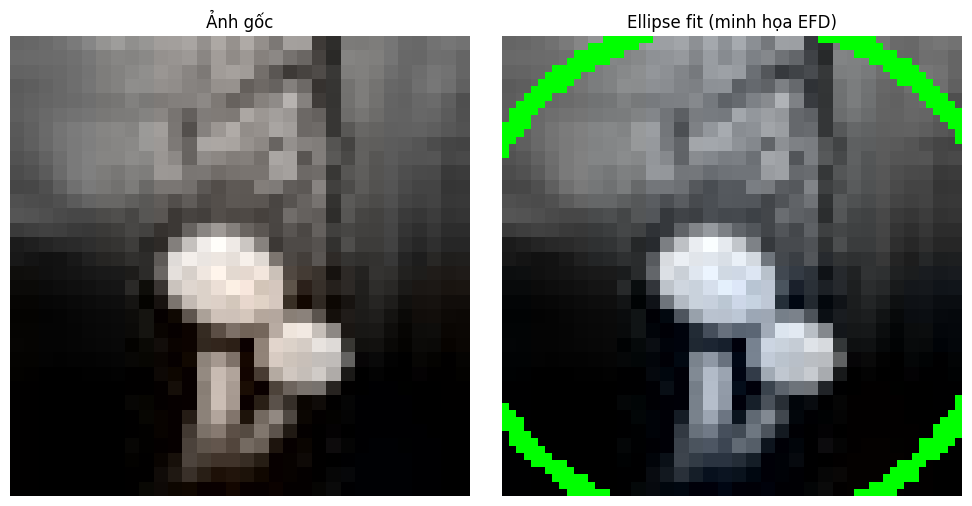

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Giả sử hàm extract_efd_features đã được định nghĩa trong DataLoader như sau:
def extract_efd_features(image, n_harmonics=10):
    """
    Tạo đặc trưng EFD (Elliptic Fourier Descriptors) từ đường bi của đối tượng.
    Trả về vector có dạng [A1, B1, C1, D1, A2, B2, C2, D2, ..., A_n, B_n, C_n, D_n].
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        cnt = cnt.squeeze()
        if cnt.ndim < 2 or cnt.shape[0] < 5:
            return np.zeros(n_harmonics * 4)
        # Tính toán EFD sử dụng pyefd
        from pyefd import elliptic_fourier_descriptors
        coeffs = elliptic_fourier_descriptors(cnt, order=n_harmonics, normalize=True)
        return coeffs.flatten()
    return np.zeros(n_harmonics * 4)

# ---- Sử dụng hàm extract_efd_features ----

# Đường dẫn ảnh mẫu (chỉnh sửa theo dữ liệu của bạn)
img_path = "/kaggle/input/aio-hutech/train/linh chi trắng/LC001.jpg"  # Thay your_image.jpg bằng ảnh thực tế

# Load ảnh và resize (ví dụ: 64x64 để dễ quan sát ellipse)
img = load_img(img_path, target_size=(64, 64))
img_array = img_to_array(img) / 255.0
# Chuyển ảnh về uint8 cho các thao tác của OpenCV
img_uint8 = (img_array * 255).astype(np.uint8)

# Trích xuất vector EFD
efd_vector = extract_efd_features(img_uint8, n_harmonics=10)
print("EFD vector:", efd_vector)

# Để minh họa, ta cũng vẽ ellipse được fit lên đường bi của đối tượng:
gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if contours:
    cnt = max(contours, key=cv2.contourArea)
    if cnt.shape[0] >= 5:  # Fit ellipse yêu cầu ít nhất 5 điểm
        ellipse = cv2.fitEllipse(cnt)
        img_with_ellipse = img_uint8.copy()
        cv2.ellipse(img_with_ellipse, ellipse, (0,255,0), 2)
    else:
        img_with_ellipse = img_uint8.copy()
else:
    img_with_ellipse = img_uint8.copy()

# Hiển thị ảnh gốc và ảnh với ellipse
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_array)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1,2,2)
# Chuyển ảnh từ BGR (OpenCV) sang RGB nếu cần
plt.imshow(cv2.cvtColor(img_with_ellipse, cv2.COLOR_BGR2RGB))
plt.title("Ellipse fit (minh họa EFD)")
plt.axis("off")

plt.tight_layout()
plt.show()

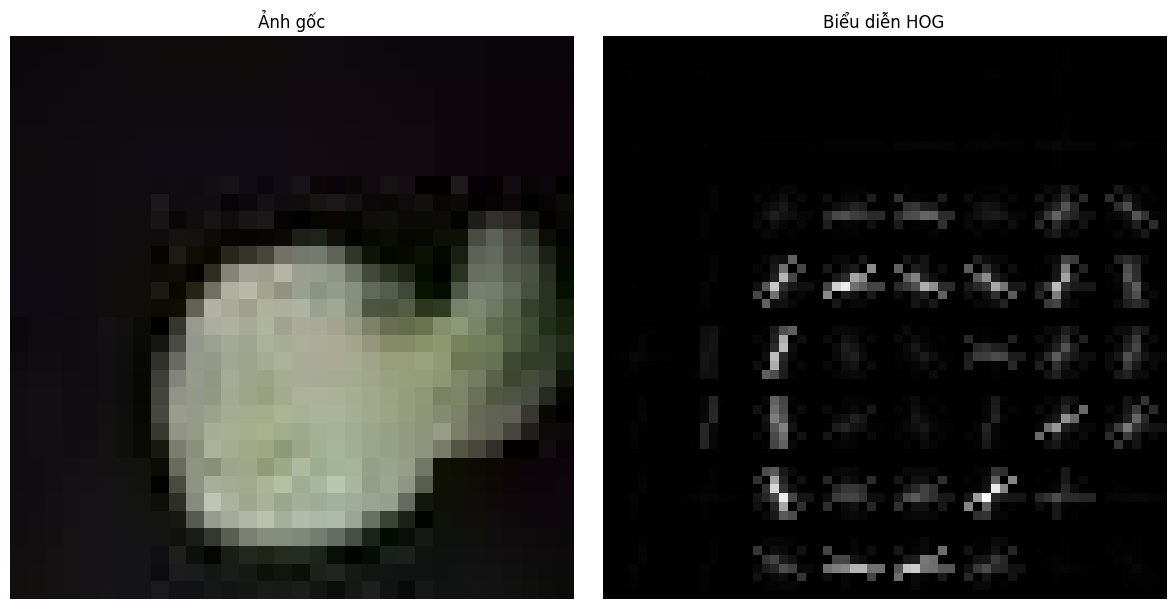

HOG feature vector shape: (1764,)


In [10]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.feature import hog

def extract_hog_features(image):
    """
    Trích xuất đặc trưng HOG từ ảnh.
    - Chuyển ảnh về grayscale.
    - Tính toán HOG với visualize=True để có thể trực quan hóa biểu diễn HOG.
    
    Returns:
      - hog_features: Vector đặc trưng HOG (1D).
      - hog_image: Hình ảnh trực quan hóa HOG.
    """
    # Chuyển ảnh về grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Tính HOG và nhận thêm hình ảnh minh họa
    hog_features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), block_norm="L2-Hys",
                                  visualize=True, feature_vector=True)
    return hog_features, hog_image

# ---- Ví dụ sử dụng hàm extract_hog_features ----

# Đường dẫn ảnh mẫu (thay 'your_image.jpg' bằng tên file cụ thể từ dataset của bạn)
img_path = "/kaggle/input/aio-hutech/train/bào ngư xám + trắng/BN003.jpg"
# Load ảnh và resize (sử dụng kích thước lớn hơn nếu cần để trực quan hóa tốt hơn HOG)
img = load_img(img_path, target_size=(64, 64))
img_array = img_to_array(img) / 255.0

# Chuyển ảnh sang uint8 để phù hợp với các hàm của OpenCV
img_uint8 = (img_array * 255).astype(np.uint8)

# Trích xuất đặc trưng HOG và hình minh họa
hog_features, hog_vis = extract_hog_features(img_uint8)

# Hiển thị ảnh gốc và biểu diễn HOG
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_vis, cmap='gray')
plt.title("Biểu diễn HOG")
plt.axis("off")

plt.tight_layout()
plt.show()

print("HOG feature vector shape:", hog_features.shape)

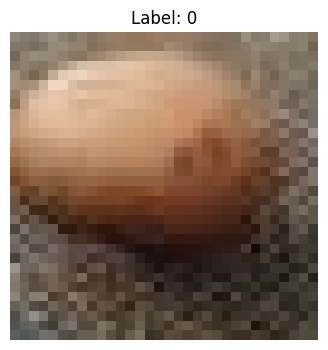

In [11]:
# Chọn một tấm ảnh bất kỳ (ngẫu nhiên)
idx = np.random.randint(0, len(X_train))
selected_image = X_train[idx]

# Hiển thị ảnh đã chọn
plt.figure(figsize=(4,4))
plt.imshow(selected_image)
plt.title(f"Label: {y_train[idx]}")
plt.axis("off")
plt.show()

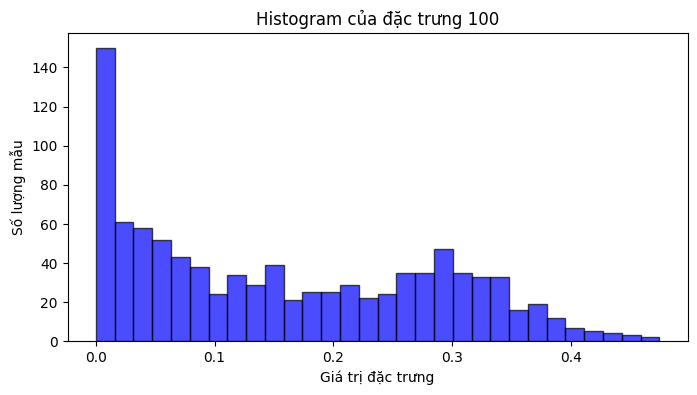

Đặc trưng 100:
Giá trị trung bình: 0.15786382469827032
Độ lệch chuẩn: 0.1262070415749174
Min: 0.0 Max: 0.4744887492625665


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử F_train có shape (n_samples, n_features)
# Ví dụ: F_train shape: (960, 544)

# Chọn cột đặc trưng số 10 (bạn có thể thay số 10 bằng chỉ số đặc trưng khác)
feature_index = 100
selected_feature = F_train[:, feature_index]

# Hiển thị histogram của đặc trưng được chọn
plt.figure(figsize=(8, 4))
plt.hist(selected_feature, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title(f"Histogram của đặc trưng {feature_index}")
plt.xlabel("Giá trị đặc trưng")
plt.ylabel("Số lượng mẫu")
plt.show()

# In ra một số thống kê mô tả
print(f"Đặc trưng {feature_index}:")
print("Giá trị trung bình:", np.mean(selected_feature))
print("Độ lệch chuẩn:", np.std(selected_feature))
print("Min:", np.min(selected_feature), "Max:", np.max(selected_feature))

# Model

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def se_block(x, filters, ratio=16):
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // ratio, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    return layers.Multiply()([x, se])
    
def build_cnn(input_shape):
    inputs = layers.Input(shape=input_shape, name="CNN_Input")

    x = layers.Conv2D(32, (3, 3), padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.SeparableConv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    residual = layers.Conv2D(128, (1, 1), padding="same", use_bias=False)(x)
    x = layers.SeparableConv2D(128, (3, 3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Add()([x, residual])
    
    x = se_block(x, 128)  # Thêm SE block
    x = layers.GlobalAveragePooling2D()(x)

    cnn_output = layers.Dense(128, activation="relu")(x)
    return Model(inputs, cnn_output, name="CNN_Branch")

def build_mlp(input_dim, name="MLP_Branch"):
    inputs = layers.Input(shape=(input_dim,), name=name + "_Input")
    
    # Block 1: mở rộng không gian đặc trưng
    x = layers.Dense(256, activation=tf.nn.silu)(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Residual block: giữ kích thước 256
    residual = x
    x = layers.Dense(256, activation=tf.nn.silu)(x)  # Sử dụng 256 thay vì 128
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Add()([x, residual])
    
    # Block 2: giảm kích thước
    x = layers.Dense(64, activation=tf.nn.silu)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    mlp_output = layers.Dense(32, activation="relu")(x)
    return Model(inputs, mlp_output, name=name)

# Sửa build_hybrid_model để dùng attention_fusion() mới
def build_hybrid_model(img_shape, feature_dim, num_classes):
    cnn_branch = build_cnn(img_shape)
    mlp_branch = build_mlp(feature_dim, name="MLP_Branch")
    
    merged = layers.concatenate([cnn_branch.output, mlp_branch.output])
    x = layers.Dense(256, activation="gelu")(merged)
    x = layers.LayerNormalization()(x)
    output = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=[cnn_branch.input, mlp_branch.input], outputs=output)
    return model

# 🏁 Khởi tạo model
img_shape = (32, 32, 3)           # Kích thước ảnh
feature_shape = F_train.shape[1]   # Chiều vector đặc trưng

num_classes = 4                   # Số loại nấm

model = build_hybrid_model(img_shape, feature_shape, num_classes)

# 🔧 Cấu hình model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 📜 Kiểm tra kiến trúc model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ CNN_Input (InputLayer)    │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            864 │ CNN_Input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 16, 16, 64)     │          2,336 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 64)     │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MLP_Branch_Input          │ (None, 1017)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        260,608 │ MLP_Branch_Input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 8, 8, 128)      │          8,768 │ max_pooling2d_1[0][0]  │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256)            │            512 │ dense_3[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 128)      │            512 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ layer_normalization[0… │
├──────────────────────

 Total params: 428,588 (1.63 MB)

 Trainable params: 428,140 (1.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
history = model.fit(
    [X_train, F_train],
    y_train,
    validation_data=([X_test, F_test], y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.3768 - loss: 1.4949 - val_accuracy: 0.2500 - val_loss: 1.4553
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6685 - loss: 0.8209 - val_accuracy: 0.2583 - val_loss: 1.6496
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8417 - loss: 0.4506 - val_accuracy: 0.2583 - val_loss: 1.9480
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8474 - loss: 0.4171 - val_accuracy: 0.2625 - val_loss: 2.6711
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8433 - loss: 0.4004 - val_accuracy: 0.3875 - val_loss: 2.6272
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8783 - loss: 0.3481 - val_accuracy: 0.2958 - val_loss: 4.6195
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8607 - loss: 0.3596 - val_accuracy: 0.3333 - val_loss: 4.2356
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8421 - loss: 0.4049 - val_accuracy: 0.3750 - val_los

In [15]:
# 🏁 Đánh giá model trên tập test
test_loss, test_acc = model.evaluate(
    [X_test, F_test], y_test
)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# 🏁 Dự đoán kết quả trên tập test
y_pred_probs = model.predict([X_test, F_test])
y_pred = y_pred_probs.argmax(axis=1)  # Chuyển từ xác suất thành nhãn dự đoán

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9697 - loss: 0.0695 
Test Accuracy: 96.67%
Test Loss: 0.0906
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


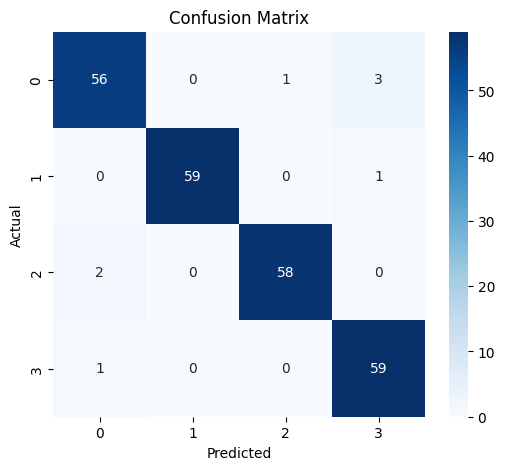

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


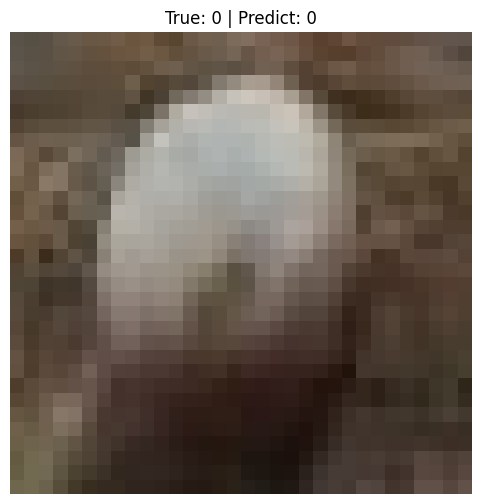

Đặc trưng đầu vào (vector F_test) của mẫu:
[ 1.66666667e-01  3.97252596e-33  8.46590340e-33 ... -5.25115600e-17
 -2.62353823e-17  1.14213690e-04]

Xác suất dự đoán của mô hình:
[[9.9999845e-01 1.0672890e-06 6.9215723e-08 3.2744197e-07]]

Nhãn dự đoán của mô hình: 0


In [17]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Chọn một mẫu ngẫu nhiên từ tập test
idx = random.randint(0, len(X_test) - 1)

sample_image = X_test[idx]        # Ảnh gốc
sample_features = F_test[idx]       # Vector đặc trưng được trích xuất
true_label = y_test[idx]            # Nhãn thực tế

# Thêm batch dimension để model nhận đầu vào dạng batch
sample_image_batch = np.expand_dims(sample_image, axis=0)       # (1, 32, 32, 3)
sample_features_batch = np.expand_dims(sample_features, axis=0)   # (1, n_features)

# Dự đoán của model
pred_probs = model.predict([sample_image_batch, sample_features_batch])
pred_label = pred_probs.argmax(axis=1)[0]

# Hiển thị ảnh gốc
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"True: {true_label} | Predict: {pred_label}", fontsize=12)
plt.show()

# In ra đầy đủ vector đặc trưng đầu vào và dự đoán của mô hình
print("Đặc trưng đầu vào (vector F_test) của mẫu:")
print(sample_features)  # In toàn bộ vector đặc trưng

print("\nXác suất dự đoán của mô hình:")
print(pred_probs)

print("\nNhãn dự đoán của mô hình:", pred_label)

In [18]:
import numpy as np
from tensorflow.keras.models import Model

# Giả sử model của bạn được xây dựng theo Functional API
# Lấy ra đầu ra của một số tầng trung gian (bỏ qua InputLayer nếu muốn)
# Nếu model có nhiều đầu vào, hãy chắc chắn rằng bạn truyền đúng danh sách đầu vào
layer_outputs = [layer.output for layer in model.layers if not isinstance(layer, tf.keras.layers.InputLayer)]

# Tạo model phụ có cùng đầu vào với model gốc nhưng đầu ra là danh sách các tầng trung gian
intermediate_model = Model(inputs=model.input, outputs=layer_outputs)

# Sử dụng một mẫu dữ liệu đầu vào (ví dụ, một batch gồm 1 mẫu)
# Lưu ý: vì model của bạn có 2 đầu vào, hãy đảm bảo cung cấp đúng định dạng:
sample_image = np.expand_dims(X_test[0], axis=0)      # (1, 32, 32, 3)
sample_features = np.expand_dims(F_test[0], axis=0)     # (1, feature_dim)

# Chạy dữ liệu qua model phụ
intermediate_outputs = intermediate_model.predict([sample_image, sample_features])

# In ra shape và một vài giá trị đầu tiên của mỗi tầng
for idx, output in enumerate(intermediate_outputs):
    layer_name = model.layers[idx+1].name  # +1 vì bỏ qua InputLayer
    print(f"Layer {idx+1} ({layer_name}): shape = {output.shape}")
    # In ra 10 giá trị đầu tiên (nếu vector)
    print(output.flatten()[:10])
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer 1 (conv2d): shape = (1, 32, 32, 32)
[-0.15234676 -0.03984727 -0.08348332  0.12198783 -0.02404146  0.14957415
  0.1142168  -0.01128842  0.08254874 -0.08888271]
--------------------------------------------------
Layer 2 (batch_normalization): shape = (1, 32, 32, 32)
[-2.7918243  -0.60378224 -0.30902588  1.5827227  -1.3058721  -0.4851576
  1.1504683   0.12231115  1.1381121  -2.0366564 ]
--------------------------------------------------
Layer 3 (leaky_re_lu): shape = (1, 32, 32, 32)
[-0.83754736 -0.18113467 -0.09270777  1.5827227  -0.39176163 -0.14554729
  1.1504683   0.12231115  1.1381121  -0.61099696]
--------------------------------------------------
Layer 4 (max_pooling2d): shape = (1, 16, 16, 32)
[-4.8912765e-04  2.0335603e+00  6.1832958e-01  1.5827227e+00
  1.0045338e+00  2.0321190e-01  1.4949727e+00  1.1009440e+00
  1.3702509e+00 -1.3475512e-01]
--------------------------------------------------
Layer 5 (separable_conv2d): shape = (1, 16, 1